In [1]:
import glob
import json
import numpy as np
import pandas as pd
import import_lakes

In [2]:
df = import_lakes.import_lake(r'./data/lakegreifenctdprofiles_datalakesdownload/*.json')

In [3]:
df

,x,z,z1,z2,z3,z4,z5,z6,z7,z8,z9
0,1.618186e+09,6.1680,0.336,0.253,90.024994,10.6,8.6485,36.299999,2.1,8.9,-3.70
1,1.618197e+09,6.2515,0.337,0.252,93.779999,11.0,8.6705,36.349998,2.2,8.7,-3.70
2,1.618208e+09,6.0395,0.335,0.253,88.274994,10.4,8.5980,37.849998,2.2,9.1,-3.80
3,1.618218e+09,6.2090,0.336,0.253,87.959999,10.3,8.6280,33.549999,2.3,7.9,-2.70
4,1.618229e+09,6.2615,0.336,0.252,88.665001,10.4,8.6410,32.650002,2.3,7.8,0.55
...,...,...,...,...,...,...,...,...,...,...,...
6369,1.610820e+09,4.5285,0.306,0.241,56.610001,6.9,10.8290,14.500000,-0.7,2.4,-3.60
6370,1.610842e+09,4.4360,0.305,0.241,56.759998,7.0,10.8315,13.400000,-0.6,2.2,-3.60
6371,1.610864e+09,4.4020,0.305,0.241,57.959999,7.1,10.8400,14.550000,-0.6,2.4,-3.60
6372,1.610885e+09,4.4250,0.306,0.241,58.990002,7.2,10.8270,12.700000,-0.6,2.0,-1.50


In [4]:
from sklearn.decomposition import PCA

In [5]:
pca = PCA(n_components=2)

In [10]:
df_no8 = df[['z','z1','z2','z3','z4','z5','z6']]

In [11]:
pca.fit(df_no8)

PCA(n_components=2)

In [12]:
print(pca.explained_variance_ratio_)

[0.9439926  0.05204318]


In [13]:
pca.components_

array([[-2.61983309e-03,  6.01555234e-01,  7.96292088e-01,
         6.35652995e-02,  6.40384360e-05, -2.01413256e-04,
        -1.65993347e-03],
       [ 7.36924403e-03,  2.78751949e-02, -1.00354600e-01,
         9.94126097e-01,  2.16086432e-02,  3.82194330e-03,
         1.81489445e-02]])

<Axes: xlabel='y(t)', ylabel='y(t + 3)'>

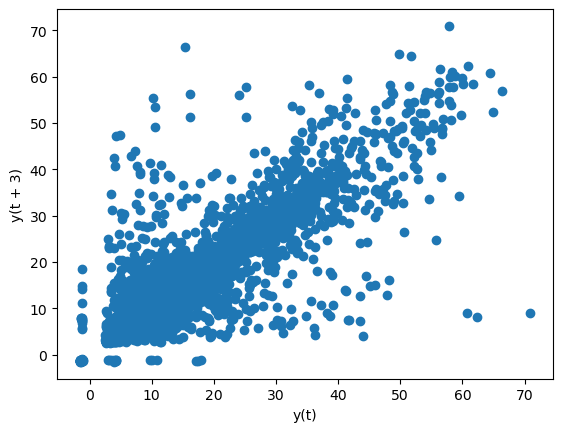

In [21]:
pd.plotting.lag_plot(df["z6"], lag=3)

In [16]:
time_step = df["x"][1] - df["x"][0]

In [19]:
print(f"Time step: {time_step} seconds")
print(f"Time step: {time_step/60/60} hours")

Time step: 10880.0 seconds
Time step: 3.0222222222222226 hours
